In [84]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from adversarial_dataset import AdversarialDataset
import os
import matplotlib.pyplot as plt
from torchvision import models
from utils import correct_torch_image, minmax_scaler, denormalize
import numpy as np

In [85]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

noise_transform = transforms.Compose([
    transforms.ToTensor()
])

In [86]:
dataset = AdversarialDataset(annotation_file="images.csv", 
                             categories_file="categories.csv", 
                             img_dir="images", 
                             noise_dir="adversarial_noise_targeted", 
                             img_transform=transform)

model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
model.eval()


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [87]:
type(dataset.categories.loc[0, "CategoryName"])

str

In [88]:
dataset[0][2]

305

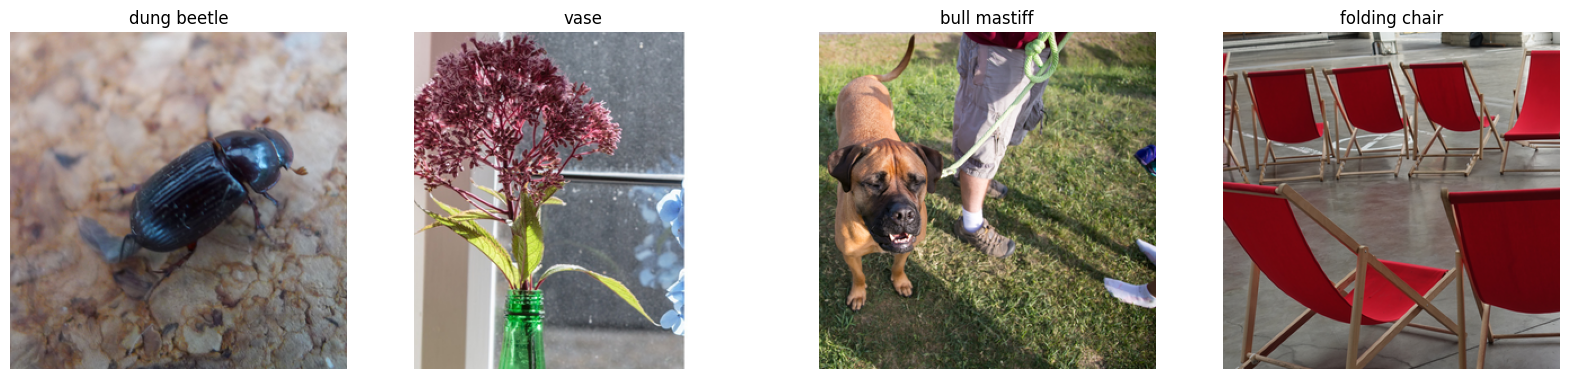

In [89]:
f, axarr = plt.subplots(1, 4, figsize=(20, 20))
for i in range(4):
    axarr[i].imshow(denormalize(correct_torch_image(dataset[i][0]), mean, std))
    axarr[i].axis('off')
    axarr[i].set_title(dataset.categories.loc[dataset[i][2], "CategoryName"])
    
plt.savefig('figures/image_examples.png', bbox_inches="tight")

In [90]:
image = dataset[3][0][None]
print(image.shape)
output = model(image)

torch.Size([1, 3, 299, 299])


In [91]:
probs = torch.nn.functional.softmax(output, dim=1)
idx = torch.argmax(probs, dim=1)[0].item()
prob = probs[0, idx].item()
label = dataset.categories.loc[idx, "CategoryName"]

print(prob, label)

0.7888859510421753 folding chair


740

In [107]:
noise_image = dataset[3][0] + dataset[3][1]
noise_output = model(noise_image[None])
noise_probs = torch.nn.functional.softmax(noise_output, dim=1)
noise_idx = torch.argmax(noise_probs, dim=1)[0].item()
noise_prob = noise_probs[0, noise_idx].item()
noise_label = dataset.categories.loc[noise_idx, "CategoryName"]
print(noise_prob, noise_label)

0.20005565881729126 power drill


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


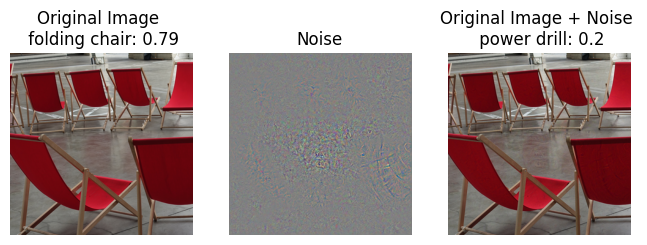

In [113]:
f, axarr = plt.subplots(1, 3, figsize=(8, 8))

im_idx = 3
axarr[0].imshow(denormalize(correct_torch_image(dataset[im_idx][0]), mean, std))
axarr[0].axis('off')
axarr[0].set_title(f'Original Image \n {label}: {round(prob, 2)}')
axarr[1].imshow(correct_torch_image(minmax_scaler(dataset[im_idx][1])))
axarr[1].axis('off')
axarr[1].set_title('Noise')
axarr[2].imshow(denormalize(correct_torch_image(dataset[im_idx][0]) + correct_torch_image(dataset[im_idx][1]), mean, std))
axarr[2].axis('off')
axarr[2].set_title(f'Original Image + Noise \n {noise_label}: {round(noise_prob, 2)}')

plt.savefig('figures/noise.png', bbox_inches="tight")

In [83]:
dataset.categories.loc[dataset[3][3], "CategoryName"]

'power drill'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


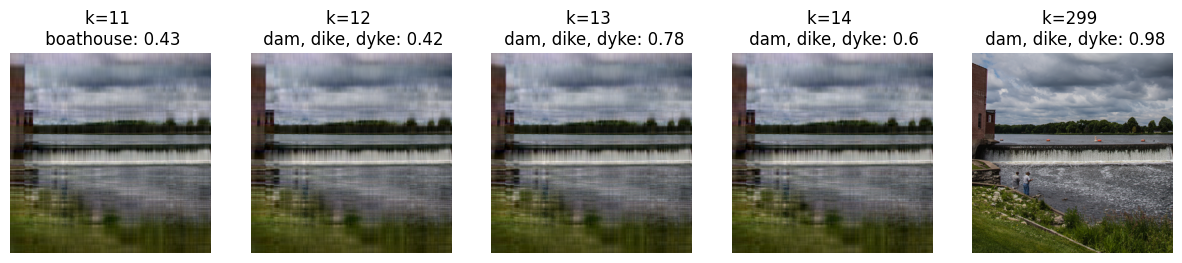

In [122]:
from sklearn.utils.extmath import randomized_svd

image = dataset[40][0]
img = np.concatenate([image[0, :, :].numpy(), image[1, :, :].numpy(), image[2, :, :].numpy()], axis=1)
_, _, WT = randomized_svd(img, n_components=299, random_state=0)

f, axarr = plt.subplots(1, 5, figsize=(15, 15))

for i, k in enumerate([11, 12, 13, 14, 299]):
    WT_k = WT[:k, :]
    X_k = img @ WT_k.T @ WT_k

    final_image = np.stack([
        X_k[:, :image.shape[1]],
        X_k[:, image.shape[1]:image.shape[1]*2],
        X_k[:, image.shape[1]*2:]
    ])
    final_image = torch.Tensor(final_image)
    
    output = model(final_image[None])
    probs = torch.nn.functional.softmax(output, dim=1)
    idx = torch.argmax(probs, dim=1)[0].item()
    prob = probs[0, idx].item()
    label = dataset.categories.loc[idx, "CategoryName"]
    
    axarr[i].imshow(denormalize(correct_torch_image(final_image), mean, std))
    axarr[i].axis('off')
    axarr[i].set_title(f'k={k} \n {label}: {round(prob, 2)}')
    

plt.savefig('figures/rowpca', bbox_inches="tight")